[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Fine-Tune YOLO for Parking Space Monitoring**

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

## ðŸŽ¯ Objective

This notebook details the process of building a smart parking monitoring system using a custom-trained YOLO segmentation model. The system is designed to analyze a video feed of a parking lot, detect vehicles, and determine the real-time occupancy status (occupied or empty) of predefined parking spaces.


## ðŸš€ Key Features

* **Data Preparation**: Convert annotations from PASCAL VOC XML format to the YOLO segmentation format.
* **Model Training**: Fine-tune a YOLOv8 nano segmentation model for vehicle detection.
* **Occupancy Detection**: Implement logic to determine parking space status using Intersection over Union (IoU) between detected vehicle masks and predefined parking polygons.
* **Real-time Visualization**: Generate an output video with colored overlays indicating the status of each parking space and a live counter of available spots.


## ðŸ“š Libraries & Prerequisites

* **Core Libraries**: `ultralytics`, `opencv-python`, `numpy`, `PIL`, `pickle`.
* **Environment**: A Python environment with GPU support is recommended for faster training.
* **Dataset**: You will need a video of a parking lot, a `.pkl` file containing the coordinates of parking spaces, and vehicle annotations in PASCAL VOC XML format.


### **Dataset Creation and Annotation**

We start by preparing our dataset for training. First, we clone a utility repository containing a helper script. We then use the `convert_voc_to_yolo_segmentation` function to convert our PASCAL VOC XML annotations into the YOLO segmentation format, which also splits the data into training and validation sets.

In [ ]:
!git clone https://github.com/Labellerr/yolo_finetune_utils.git

In [2]:
from yolo_finetune_utils.frame_extractor import extract_random_frames

extract_random_frames(paths=[r"assests\1.mp4"], 
                      out_dir='dataset-2', 
                      total_images=10,
                      seed=42)

[âœ“] Extracted 10 frames to folder: dataset-2


### **Converting COCO-JSON to YOLO format**


In [4]:
from yolo_finetune_utils.coco_yolo_converter.bbox_converter import coco_to_yolo_converter

coco_to_yolo_converter(json_path="annotations.json", images_dir="dataset-2", output_dir="yolo_format-2")

Loading COCO dataset from annotations.json
Found 2 images and 550 annotations
Categories mapping:
  COCO ID 0 (Vehicle) -> YOLO class 0
Images with annotations: 2

Processing all split...

Conversion completed:
  Successfully processed: 2 images
  Failed to find: 0 images
  Total annotations converted: 550
  Categories: 1

YOLO dataset created at: yolo_format-2
Dataset configuration: yolo_format-2\dataset.yaml


{'output_path': 'yolo_format-2',
 'yaml_path': 'yolo_format-2\\dataset.yaml',
 'stats': {'total_images': 2,
  'images_with_annotations': 2,
  'successful_copies': 2,
  'failed_copies': 0,
  'total_annotations': 550,
  'categories': 1,
  'category_mapping': {0: 0},
  'class_names': {0: 'Vehicle'}}}

### **Model Training**

With the dataset correctly formatted, we proceed to train our YOLOv8 nano segmentation model. Using a pre-trained `yolov8n-seg.pt` checkpoint allows us to leverage transfer learning for better and faster results. The model is trained for 100 epochs on our custom vehicle dataset.

In [5]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [ ]:
!yolo task=detect mode=train data="path/to/dataset.yaml" model="yolov8x.pt" epochs=200 imgsz=640 batch=30


0: 384x640 300 Vehicles, 1159.1ms
Speed: 13.6ms preprocess, 1159.1ms inference, 16.3ms postprocess per image at shape (1, 3, 384, 640)


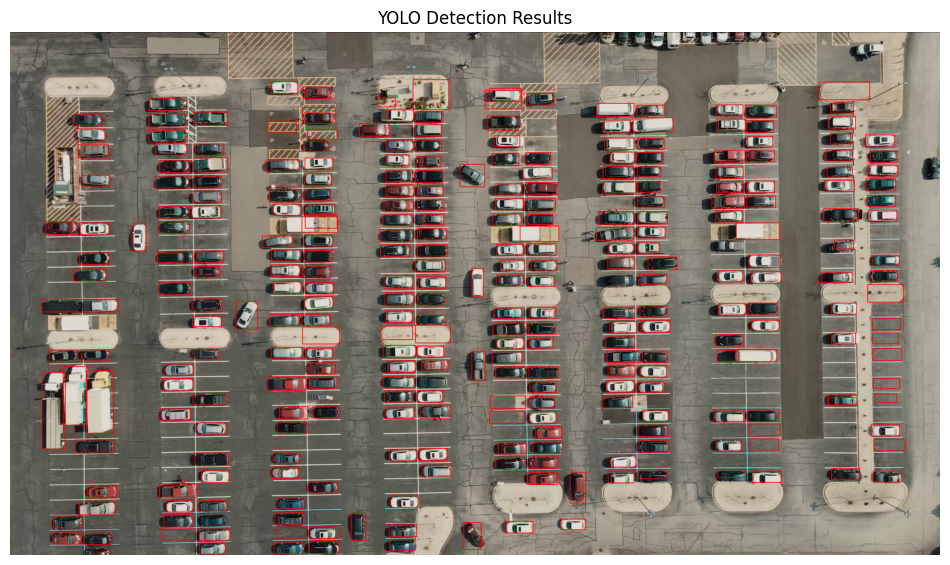

In [6]:
model = YOLO("./runs/detect/train/weights/last.pt")  # load a custom model

frame = cv2.imread("sample_frame.jpg")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

result = model.predict(source=frame_rgb, conf=0.25)  # predict on an image

for box in result[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.axis('off')  # Hide axes
plt.title('YOLO Detection Results')
plt.show()

### **Logic Building**

This is the core of our monitoring system. We begin by loading our custom-trained model and the predefined parking space coordinates from a pickle file. We then define a crucial function, `get_parking_space_status`, which calculates the Intersection over Union (IoU) between detected vehicle masks and the parking space polygons to determine if a space is occupied.

In [8]:
video_path = r"assests\1.mp4"

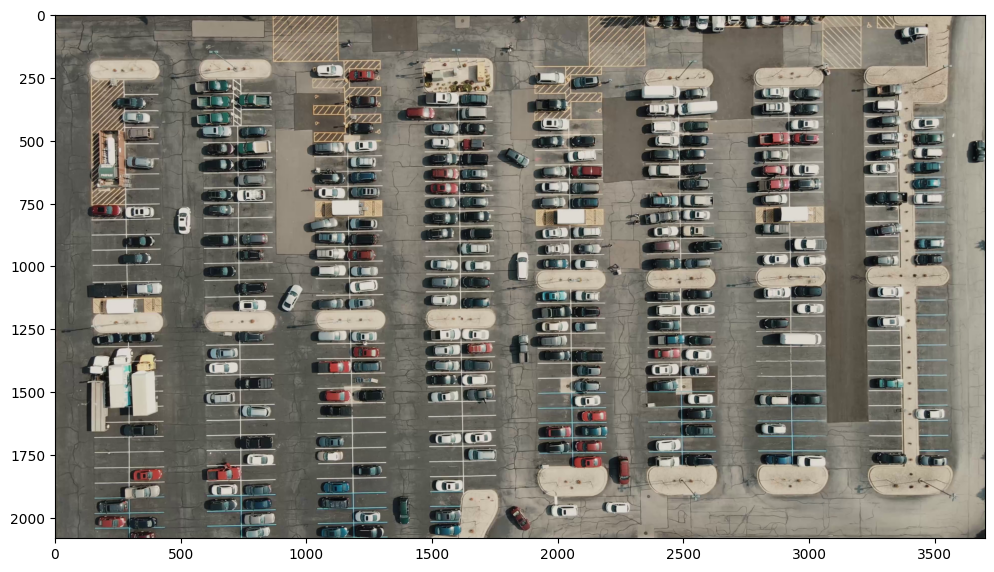

In [15]:
cap = cv2.VideoCapture(video_path)

cap.set(cv2.CAP_PROP_POS_FRAMES, 30)  # Set to desired frame
ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Plot the frame
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)

# cv2.imwrite("sample_frame.jpg", frame)

In [16]:
# Mouse callback function
coordinates = []

def get_pixel_coordinates(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # left mouse click
        # print(f"Coordinates: (x={x}, y={y})")
        coordinates.append((x, y))
        cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)

# Load video
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 30)  # Set to desired frame
ret, frame = cap.read()
if not ret:
    print("Failed to read video frame")
    cap.release()
    exit()

cv2.namedWindow("Frame", cv2.WINDOW_GUI_EXPANDED)
cv2.setMouseCallback("Frame", get_pixel_coordinates)

while True:
    cv2.imshow("Frame", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # Press ESC to exit
        break

cap.release()
cv2.destroyAllWindows()

print(coordinates)

[(331, 291), (331, 353), (337, 407), (331, 478), (334, 546), (334, 600), (331, 665), (331, 725), (329, 784), (331, 846), (337, 903), (343, 971), (343, 1031), (343, 1090)]


Total parking spots: 393


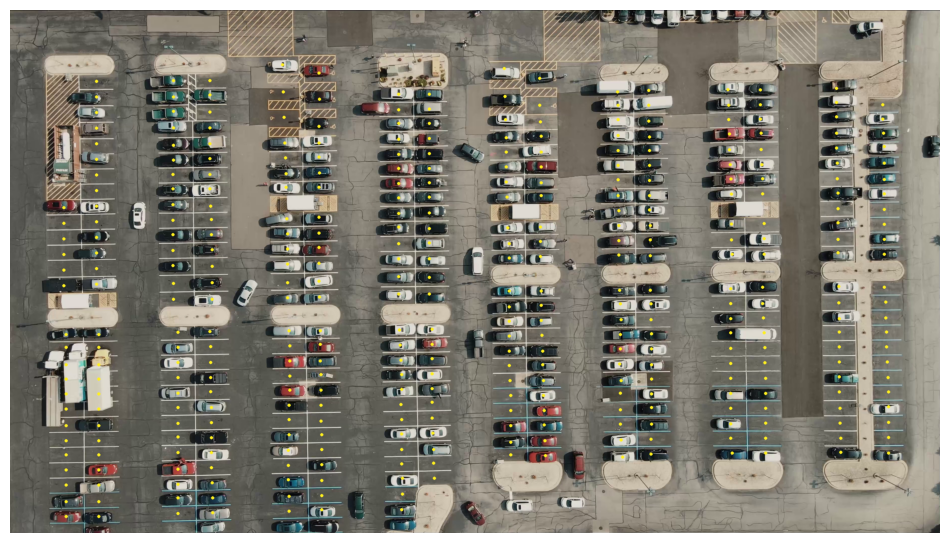

In [18]:
cap = cv2.VideoCapture(video_path)

row1_upper = [(214, 789), (214, 851), (214, 913), (214, 975), (214, 1037), (214, 1099)]
row1_lower = [(223, 1293), (223, 1344), (223, 1413), (223, 1470), (223, 1529), (223, 1589), (223, 1655), (223, 1715), (223, 1771), (223, 1831), (223, 1891), (223, 1957), (223, 2016)]

row2_upper = [(344, 287), (344, 349), (344, 411), (344, 473), (344, 535), (344, 597), (344, 659), (344, 721), (344, 783), (344, 845), (344, 907), (344, 969), (344, 1031), (344, 1093)]
row2_lower = [(353, 1293), (353, 1344), (353, 1413), (353, 1470), (353, 1529), (353, 1589), (353, 1655), (353, 1715), (353, 1771), (353, 1831), (353, 1891), (353, 1957), (353, 2016)]

row3_upper = [(650, 284), (650, 349), (650, 406), (650, 472), (650, 541), (650, 600), (648, 657), (648, 714), (648, 777), (648, 839), (648, 896), (648, 959), (648, 1019), (650, 1090), (650, 1153)]
row3_lower = [(668, 1284), (668, 1344), (668, 1404), (668, 1464), (668, 1526), (668, 1583), (668, 1646), (668, 1700), (668, 1762), (668, 1828), (668, 1888), (668, 1942), (668, 2004)]

row4_upper = [(795, 284), (795, 341), (795, 409), (795, 472), (795, 535), (795, 594), (795, 657), (795, 714), (798, 783), (801, 836), (801, 896), (804, 956), (804, 1022), (804, 1087), (804, 1153)]
row4_lower = [(795, 1281), (798, 1341), (798, 1404), (798, 1464), (798, 1520), (801, 1583), (801, 1643), (801, 1703), (801, 1762), (801, 1822), (804, 1882), (806, 1942), (806, 2001)]

row5_upper = [(1084, 221), (1087, 329), (1090, 430), (1093, 532), (1096, 591), (1098, 654), (1098, 708), (1101, 833), (1104, 893), (1104, 953), (1104, 1013), (1104, 1087), (1104, 1147)]
row5_lower = [(1110, 1278), (1113, 1338), (1113, 1398), (1113, 1458), (1113, 1514), (1110, 1574), (1110, 1631), (1110, 1691), (1107, 1753), (1107, 1813), (1107, 1870), (1110, 1936), (1110, 1995)]

row6_upper = [(1229, 254), (1231, 358), (1229, 466), (1229, 532), (1229, 588), (1231, 651), (1229, 708), (1229, 827), (1229, 890), (1229, 947), (1229, 1010), (1229, 1081), (1231, 1144)]
row6_lower = [(1234, 1278), (1234, 1332), (1234, 1398), (1237, 1452), (1237, 1514), (1237, 1574), (1237, 1637), (1240, 1691), (1240, 1750), (1240, 1810), (1240, 1873), (1240, 1933), (1240, 1989)]

row7_upper = [(1546, 338), (1546, 400), (1546, 454), (1546, 517), (1546, 577), (1546, 633), (1546, 693), (1546, 750), (1546, 812), (1546, 866), (1546, 932), (1546, 992), (1546, 1063), (1546, 1132)]
row7_lower = [(1549, 1275), (1552, 1335), (1555, 1395), (1558, 1452), (1558, 1511), (1555, 1571), (1558, 1631), (1558, 1688), (1558, 1750), (1558, 1807), (1561, 1864), (1561, 1927), (1558, 1989)]

row8_upper = [(1668, 338), (1668, 397), (1668, 454), (1668, 514), (1668, 574), (1668, 633), (1668, 690), (1668, 747), (1668, 810), (1668, 872), (1668, 929), (1668, 992), (1668, 1066), (1668, 1132)]
row8_lower = [(1679, 1272), (1679, 1332), (1679, 1389), (1679, 1449), (1679, 1508), (1679, 1562), (1679, 1625), (1682, 1685), (1685, 1750), (1685, 1804), (1688, 1864)]

row9_upper = [(1966, 236), (1969, 347), (1971, 439), (1974, 511), (1974, 568), (1974, 627), (1974, 687), (1977, 747), (1980, 869), (1986, 932), (1986, 989)]
row9_lower = [(1986, 1120), (1986, 1183), (1986, 1240), (1986, 1299), (1986, 1359), (1986, 1416), (1989, 1476), (1992, 1535), (1992, 1595), (1992, 1655), (1992, 1721), (1992, 1771)]

row10_upper = [(2107, 275), (2107, 382), (2110, 448), (2113, 505), (2113, 568), (2113, 627), (2113, 690), (2113, 741), (2110, 866), (2110, 923), (2110, 983)]
row10_lower = [(2113, 1120), (2113, 1177), (2113, 1237), (2116, 1296), (2119, 1359), (2119, 1413), (2122, 1476), (2122, 1535), (2125, 1595), (2125, 1652), (2128, 1715), (2130, 1774)]

row11_upper = [(2417, 329), (2419, 382), (2419, 439), (2419, 502), (2419, 562), (2419, 621), (2419, 678), (2419, 741), (2422, 801), (2422, 860), (2422, 920), (2422, 977)]
row11_lower = [(2425, 1117), (2428, 1171), (2431, 1234), (2428, 1293), (2428, 1350), (2425, 1410), (2431, 1476), (2428, 1526), (2428, 1592), (2428, 1649), (2431, 1712), (2437, 1780)]

row12_upper = [(2541, 323), (2541, 382), (2541, 445), (2544, 508), (2544, 562), (2544, 621), (2544, 681), (2544, 741), (2544, 798), (2547, 860), (2547, 917), (2547, 980)]
row12_lower = [(2547, 1117), (2550, 1171), (2550, 1234), (2552, 1290), (2552, 1350), (2552, 1413), (2552, 1470), (2552, 1529), (2552, 1583), (2552, 1649), (2550, 1709), (2550, 1768)]

row13_upper = [(2856, 320), (2859, 382), (2859, 439), (2862, 496), (2862, 559), (2865, 618), (2868, 675), (2870, 735), (2870, 854), (2870, 917), (2873, 974)]
row13_lower = [(2867, 1111), (2867, 1170), (2867, 1230), (2867, 1286), (2867, 1348), (2867, 1408), (2867, 1467), (2867, 1527), (2867, 1586), (2867, 1648), (2867, 1705), (2873, 1764)]

row14_upper = [(2985, 321), (2985, 380), (2985, 437), (2988, 493), (2988, 558), (2991, 618), (2994, 674), (2994, 734), (3000, 852), (3000, 912), (3000, 974)]
row14_lower = [(2994, 1105), (2994, 1170), (2997, 1227), (3000, 1286), (3003, 1345), (3003, 1405), (3006, 1467), (3006, 1527), (3006, 1586), (3006, 1645), (3006, 1705), (3006, 1764)]

row15_upper = [(3288, 315), (3288, 371), (3288, 428), (3288, 493), (3288, 552), (3291, 612), (3291, 674), (3294, 731), (3294, 793), (3294, 849), (3294, 915), (3294, 968)]
row15_lower = [(3297, 1102), (3297, 1167), (3299, 1230), (3299, 1283), (3299, 1342), (3299, 1402), (3299, 1461), (3299, 1521), (3302, 1586), (3302, 1645), (3305, 1705), (3305, 1761)]

row16_upper = [(3472, 380), (3472, 437), (3475, 493), (3478, 546), (3478, 612), (3478, 677), (3478, 734), (3478, 796), (3478, 855), (3478, 915), (3478, 974)]
row16_lower = [(3478, 1105), (3484, 1164), (3484, 1227), (3487, 1283), (3487, 1342), (3490, 1402), (3493, 1464), (3495, 1521), (3495, 1580), (3495, 1642), (3495, 1702), (3495, 1764)]

parking_spots = (row1_upper + row1_lower + row2_lower + row2_upper + 
                 row3_upper + row3_lower + row4_upper + row4_lower + 
                 row5_upper + row5_lower + row6_upper + row6_lower + 
                 row7_upper + row7_lower + row8_upper + row8_lower + 
                 row9_upper + row9_lower + row10_upper + row10_lower + 
                 row11_upper + row11_lower + row12_upper + row12_lower + 
                 row13_upper + row13_lower + row14_upper + row14_lower + 
                 row15_upper + row15_lower + row16_upper + row16_lower)

cap.set(cv2.CAP_PROP_POS_FRAMES, 30) # Set to desired frame
ret, frame = cap.read()
cap.release()


for p in parking_spots:
    cv2.circle(frame, p, 5, (31, 240, 255), -2)
    cv2.circle(frame, p, 5, (31, 240, 255), 2)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(frame_rgb)

print(f"Total parking spots: {len(parking_spots)}")

Finally, we create the main `parking_monitoring_system` function. This function reads the input video frame by frame, applies our trained model, uses the IoU logic to check the status of each spot, and writes an output video with visual overlays. Occupied spaces are colored red, empty spaces are green, and a live counter shows the number of available spots.

In [19]:
def parking_monitoring_system(parking_spots, model_path, input_video_path, output_video_path, confidence_threshold=0.5):
    """
    Parking monitoring system using YOLO for car detection and predefined parking spots.
    
    Args:
        parking_spots (list): List of tuples containing (x, y) coordinates of parking spot centers
        model_path (str): Path to the YOLO model file
        input_video_path (str): Path to input video file
        output_video_path (str): Path to save the output video
        confidence_threshold (float): Confidence threshold for YOLO detections
    """
    
    # Load YOLO model
    model = YOLO(model_path)
    
    # Open video
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Define codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    print(f"Processing video: {input_video_path}")
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    print(f"Total parking spots: {len(parking_spots)}")
    
    frame_count = 0
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_count += 1
            
            # Run YOLO inference
            results = model(frame, conf=confidence_threshold, verbose=False)
            
            # Get bounding boxes for detected cars
            car_boxes = []
            for result in results:
                boxes = result.boxes
                if boxes is not None:
                    for box in boxes:
                        # Get class name
                        class_id = int(box.cls[0])
                        class_name = model.names[class_id]
                        
                        # Filter for car-related classes
                        if class_name.lower() in ['car', 'vehicle', 'automobile', 'truck', 'bus']:
                            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                            car_boxes.append([int(x1), int(y1), int(x2), int(y2)])
            
            # Check each parking spot
            empty_spots = 0
            occupied_spots = 0
            
            for spot_x, spot_y in parking_spots:
                is_occupied = False
                
                # Check if parking spot center is inside any car bounding box
                for x1, y1, x2, y2 in car_boxes:
                    if x1 <= spot_x <= x2 and y1 <= spot_y <= y2:
                        is_occupied = True
                        break
                
                # Draw parking spot
                if is_occupied:
                    # Red circle for occupied spot
                    cv2.circle(frame, (spot_x, spot_y), 8, (0, 0, 255), -1)
                    cv2.circle(frame, (spot_x, spot_y), 10, (0, 0, 255), 2)
                    occupied_spots += 1
                else:
                    # Green circle for empty spot
                    cv2.circle(frame, (spot_x, spot_y), 8, (0, 255, 0), -1)
                    cv2.circle(frame, (spot_x, spot_y), 10, (0, 255, 0), 2)
                    empty_spots += 1
            
            # Draw car bounding boxes
            for x1, y1, x2, y2 in car_boxes:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(frame, 'Car', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Create info panel at upper right 
            panel_width = 600
            panel_height = 240
            panel_x = width - panel_width - 20
            panel_y = 20
            
            # Draw semi-transparent background
            overlay = frame.copy()
            cv2.rectangle(overlay, (panel_x, panel_y), (panel_x + panel_width, panel_y + panel_height), (0, 0, 0), -1)
            cv2.addWeighted(overlay, 0.7, frame, 0.3, 0, frame)
            
            # Draw border
            cv2.rectangle(frame, (panel_x, panel_y), (panel_x + panel_width, panel_y + panel_height), (255, 255, 255), 2)
            
            # Add text information (increased font size by 2x)
            text_y = panel_y + 60
            cv2.putText(frame, f"Total Spots: {len(parking_spots)}", (panel_x + 20, text_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 4)
            
            text_y += 50
            cv2.putText(frame, f"Empty: {empty_spots}", (panel_x + 20, text_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 4)
            
            text_y += 50
            cv2.putText(frame, f"Occupied: {occupied_spots}", (panel_x + 20, text_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 4)
            
            text_y += 50
            occupancy_rate = (occupied_spots / len(parking_spots)) * 100 if parking_spots else 0
            cv2.putText(frame, f"Occupancy: {occupancy_rate:.1f}%", (panel_x + 20, text_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 0), 4)
            
            # Write frame to output video
            out.write(frame)
            
            # Print progress every 100 frames
            if frame_count % 100 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"Progress: {progress:.1f}% - Frame {frame_count}/{total_frames}")
                print(f"Current status - Empty: {empty_spots}, Occupied: {occupied_spots}")
        
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user")
    except Exception as e:
        print(f"Error during processing: {str(e)}")
    finally:
        # Release everything
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        
        print(f"\nProcessing completed!")
        print(f"Output video saved as: {output_video_path}")
        print(f"Processed {frame_count} frames")

In [ ]:
parking_monitoring_system(
    parking_spots=parking_spots,
    model_path="./runs/detect/train/weights/last.pt",
    input_video_path="./assests/1.mp4",
    output_video_path="output_parking_monitor_2.mp4",
    confidence_threshold=0.25
)